Note: Originally, this is a group work including modelling and prediction. **However, I have only included my part which is Data Preprocessing and EDA.**

---
**Dataset Path:** "Data/air_pollution.csv"
---

## Data Overview:
    Air pollution is the contamination of air due to harmful and toxic substances in the form of liquid, gas, or small solid elements that are present in the atmosphere acting as agents to modify the healthy nature and charcteristics of the atmosphere. These substances or pollutants are results of fuel combustion by motor vehicles, gases emitted by factories, and, last but not least, forest fires. Air pollution is a crucial risk factor of cardiovascular and lung diseases. It is actually a major contributor to cancer. The main pollutants that are closely tied to such dangers are: Carbon Monoxide(CO), Ozone, Nitrogeon Dioxide(NO2), Atmospheric Particular Matter(PM). According to the WHO, CO is a colourless, odourless and tasteless toxic gas emitted by the incomplete combustion of fuels. Ozone is a harmful gas formed through the reaction of gases presented with sunlight. NO2 is a gas that is commonly released from the combustion of fuels in the transportation and industrial sectors. PM is the mixture of small solid and liquid matters such as sulfates, nitrates, ammonia, sodium chloride, black carbon, mineral dust and water, that are in the air.

    The provided dataset has information about the mentioned pollutants and their effects in determining the overall Air Quality Index(AQI) or AQI Category. According to well-known and trusted health & enviromental govermental(airnow US) and the World Health Organization (WHO), the higher the AQI value the more dangerous and worse air quality is.

    This dataset was collected from different sources according to the country and reports. These sources include but are not limited to govermental agencies that monitor the air quality and collect data accordingly to publish them for quality data such as the US AirNow, London Air Quality Network, EEA Germany...

]

***Variables***
* Country: Name of the country
* City: Name of the city
* AQI Value: Overall AQI(Air Quality Index) value of the city
* AQI Category: Overall AQI category of the city
* CO AQI Value : AQI value of Carbon Monoxide of the city
* CO AQI Category : AQI category of Carbon Monoxide of the city
* Ozone AQI Value : AQI value of Ozone of the city
* Ozone AQI Category : AQI category of Ozone of the city
* NO2 AQI Value : AQI value of Nitrogen Dioxide of the city
* NO2 AQI Category : AQI category of Nitrogen Dioxide of the city
* PM2.5 AQI Value : AQI value of Particulate Matter with a diameter of 2.5 micrometers or less of the city
* PM2.5 AQI Category : AQI category of Particulate Matter with a diameter of 2.5 micrometers or less of the city

# **Necessary Installs**

In [1]:
#!pip install imblearn #For Data imbalance Resolution
#!pip install scipy #For calculating the chi-square

# **Necessary Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
from PIL import Image

from imblearn.over_sampling import SMOTE  
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score


from scipy.stats import chi2_contingency

# **Necessary Functions**

In [ ]:
#To visualize different plots of some data in a dataset
#dataframe: dataset to be visualized
#features: The features to plot
#type: The type of visualization
#info: Unformation to be used such as labels. [(figure_width, figure_height), figure_title, x_label, y_label]
#rotate: To rotate the xticks 30 degrees
def visualize(dataframe: pd.Dataframe, features: list, type: str, info: list, rotate: bool, n_cols: int, h_space: int) -> None:
    sns.set_theme(style="whitegrid")
    n_features = len(features)
    fig, axes = plt.subplots((n_features + n_cols - 1) // n_cols, n_cols, figsize=info[0])
    if n_cols == 1 or (n_features == 1 and n_cols == 1):
        axes = np.array([axes])
    axes = axes.flatten()
    for index, feature in enumerate(features):
        ax = axes[index]
        if(type == "histplot"):
            sns.histplot(dataframe[feature], bins=20, alpha=0.7, kde=True, ax=ax, color="#28B463")
        elif(type=="scatterfit"):
            sns.regplot(x=feature, y=info[3], data=dataframe, ax=ax, color="#28B463")
        elif(type=="countplot"):
            sns.countplot(data=dataframe, x=feature, color="#28B463", alpha=0.7, ax=ax)
        elif(type=="boxplot"):
            sns.boxplot(x=dataframe[feature], color="#28B463", ax=ax)
            inner_fence = calculate_fence(dataframe, feature, 1.5)
            outer_fence = calculate_fence(dataframe, feature, 3)
            ax.axvline(inner_fence[0], color='teal', linestyle='--', label='Inner Fence (Lower)')
            ax.axvline(inner_fence[1], color='teal', linestyle='--', label='Inner Fence (Upper)')
            ax.axvline(outer_fence[0], color='orange', linestyle='--', label='Outer Fence (Lower)')
            ax.axvline(outer_fence[1], color='orange', linestyle='--', label='Outer Fence (Upper)')
            ax.legend()
        ax.set_title(feature)
        ax.set_xlabel(info[2])
        if(rotate):
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        ax.set_ylabel(info[3])
        sns.despine(ax=ax)
    if(n_features % 2 != 0 and n_cols % 2 == 0): #To remove unused subplots
        fig.delaxes(axes[n_features])
    fig.suptitle(info[1])
    plt.subplots_adjust(wspace=0.3, hspace=h_space)
    plt.show()


#Calculates the chi-square of two columns
#dataframe: dataframe to be used
#columns: an array of two values
#return the chi-square score, p value, degree of freedom, and the expected value E
def chi_square(dataframe: pd.DataFrame, columns: list) -> tuple:
    if(len(columns) > 2):
        return False
    cross_table = pd.crosstab(dataframe[columns[0]], dataframe[columns[1]])
    chi2, p, dof, expected = chi2_contingency(cross_table)
    return (chi2, p, dof, expected)

#Calculte the outer or inner fences for outlier identification
#dataframe: dataframe to be used
#feature: to look up the outliers of a certain feature
#coef: 1.5 or 3 for inner fences and outter fences respectively
#return the lower and upper values of the fences in a list
def calculate_fence(dataframe: pd.DataFrame, feature: list, coef: int) -> list:
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    fences = [Q1 - coef*IQR, Q3 + coef*IQR]
    return fences

#Applies smote technique to an imbalanced dataset
#dataframe: the imbalanced dataset
#target: the target variable of the dataset
#sampling_strategy: how many synthetic samples will be generated in relation the minorty classes. "auto" will make the minorty classes equal to the size of the dominant groups
def apply_smote(dataframe: pd.DataFrame, target: str, sampling_strategy="auto") -> pd.DataFrame:
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    X_smote, y_smote = smote.fit_resample(X,y)
    new_df = pd.concat([X_smote, y_smote], axis=1)
    return new_df

#Applies undersampling technique to an imbalanced dataset
#dataframe: the imbalanced dataset
#target: the target variable of the dataset
#sampling_strategy: the percentage to reduce the majority classes to balance with the minority classes. "auto" will make the majority groups equal to the size of the minority groups.
def apply_undersampling(dataframe: pd.DataFrame, target: str, sampling_strategy="auto") -> pd.DataFrame:
    undersample = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    X_smote, y_smote = undersample.fit_resample(X,y)
    new_df = pd.concat([X_smote, y_smote], axis=1)
    return new_df

#Applied kmeans clustering
#dataframe: a dataframe for clustering analysis
#optimal_k: int, optimal number of k neighbors
def apply_kmean(dataframe: pd.DataFrame, optimal_k: int) -> pd.DataFrame:
    df = dataframe.copy()
    kmeans = KMeans(n_clusters=optimal_k, random_state=42,n_init="auto")
    clusters = kmeans.fit_predict(df)
    df.loc[:, "Cluster"] = clusters
    return df

# **PART- 1: Data Preprocessing and Exploration**
* Missing Values
* Duplicates
* Numerical Columns Exploration & Visualization
* Categorical Columns Exploration & Visualization
    * Ordinal Encoding
* Data Normalization
* Outlier Detection & Handling
* Cluster Analysis
* Class Reduction
* Final Datasets
---

In [4]:
original_link = "https://drive.google.com/file/d/1s-zzSq_FtmubEO6WQ2haWqKWKFX3UVln/view?usp=sharing"
id = "1s-zzSq_FtmubEO6WQ2haWqKWKFX3UVln" # original.split('/')[-2]
url = "https://drive.google.com/uc?id=" + id
df = pd.read_csv(url)
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [5]:
print(f'{df.shape[0]} rows\n{df.shape[1]} columns')

23463 rows
12 columns


## Missing Values

In [6]:
df.isna().sum()

Country               427
City                    1
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
dtype: int64

In [7]:
df[df["City"].isna()]

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
2641,Israel,NaN,68,Moderate,1,Good,48,Good,4,Good,68,Moderate


In [8]:
df[df["Country"] == "Israel"]["City"].value_counts()

City
Tamra             1
Qiryat Ono        1
Nahef             1
Ramla             1
Sederot           1
Kafar Manda       1
Kafar Qasem       1
Qiryat Yam        1
Azur              1
Netanya           1
Gedera            1
Sakhnin           1
Qiryat Gat        1
Qiryat Bialik     1
Tayibe            1
Qiryat Motzkin    1
Iksal             1
Ashqelon          1
Dimona            1
Qiryat Shemona    1
Ashdod            1
Haifa             1
Kefar Yona        1
Netivot           1
Elat              1
Qiryat Atta       1
Gan Yavne         1
Nesher            1
Bene Beraq        1
Tirat Karmel      1
Or Yehuda         1
Tiberias          1
Bat Yam           1
Reine             1
Ramat Hasharon    1
Kefar Sava        1
Nahariyya         1
Ofaqim            1
Hod Hasharon      1
Yavne             1
Beit Jann         1
Ganne Tiqwa       1
Lod               1
Ramat Gan         1
Bet Shemesh       1
Tel Aviv Yafo     1
Name: count, dtype: int64

    - There are 427 missing Country values and one missing City value.
    - The Country and City features are dependent on each other, specifically the city can determine the country.
    - Imputing the missing countries is not a valid approach, as some imputed values might not represent the corresponding cities. The only valid approach to fill the missing values would be to manually determine those values according to the cities.
**Conclusion: The Country feature will be dropped and the missing City row can be dropped without having a significant effect on the prediction models. However, both features will be used in the data preprocessing stage and will be dropped later on.**

In [9]:
#df_missing = df.drop(columns=["Country"], axis=1)
df_missing = df[df["City"].isna() == False]
print("Shape of the new dataset:", df_missing.shape)
df_missing.isna().sum()

Shape of the new dataset: (23462, 12)


Country               427
City                    0
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
dtype: int64

## Duplicates

In [10]:
df_missing.duplicated().sum()

0

<b>No duplicates in the dataset.</b>

## Numerical Data Exploration & Visualization

In [11]:
df_missing.columns

Index(['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value',
       'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category',
       'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value',
       'PM2.5 AQI Category'],
      dtype='object')

In [12]:
df_missing.info()
print("\n\n")
df_missing.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 23462 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             23035 non-null  object
 1   City                23462 non-null  object
 2   AQI Value           23462 non-null  int64 
 3   AQI Category        23462 non-null  object
 4   CO AQI Value        23462 non-null  int64 
 5   CO AQI Category     23462 non-null  object
 6   Ozone AQI Value     23462 non-null  int64 
 7   Ozone AQI Category  23462 non-null  object
 8   NO2 AQI Value       23462 non-null  int64 
 9   NO2 AQI Category    23462 non-null  object
 10  PM2.5 AQI Value     23462 non-null  int64 
 11  PM2.5 AQI Category  23462 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.3+ MB





,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
count,23462.000000,23462.000000,23462.000000,23462.000000,23462.000000
mean,72.011039,1.368383,35.193163,3.063294,68.519777
std,56.056409,1.832101,28.099198,5.254217,54.797611
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,1.000000,21.000000,0.000000,35.000000
50%,55.000000,1.000000,31.000000,1.000000,54.000000
75%,79.000000,1.000000,40.000000,4.000000,79.000000
max,500.000000,133.000000,235.000000,91.000000,500.000000


**Maximum of AQI Value is 500 but the mean is 72. The data should be skewed. Same thing applied for the rest of the numerical categories.**

In [13]:
numerical_columns = df_missing.select_dtypes(include=["int64"]).columns
numerical_columns

Index(['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value',
       'PM2.5 AQI Value'],
      dtype='object')

In [14]:
df_missing["Country"].value_counts()

Country
United States of America    2872
India                       2488
Brazil                      1562
Germany                     1345
Russian Federation          1241
                            ... 
Vanuatu                        1
Solomon Islands                1
Republic of Korea              1
Saint Lucia                    1
Monaco                         1
Name: count, Length: 175, dtype: int64

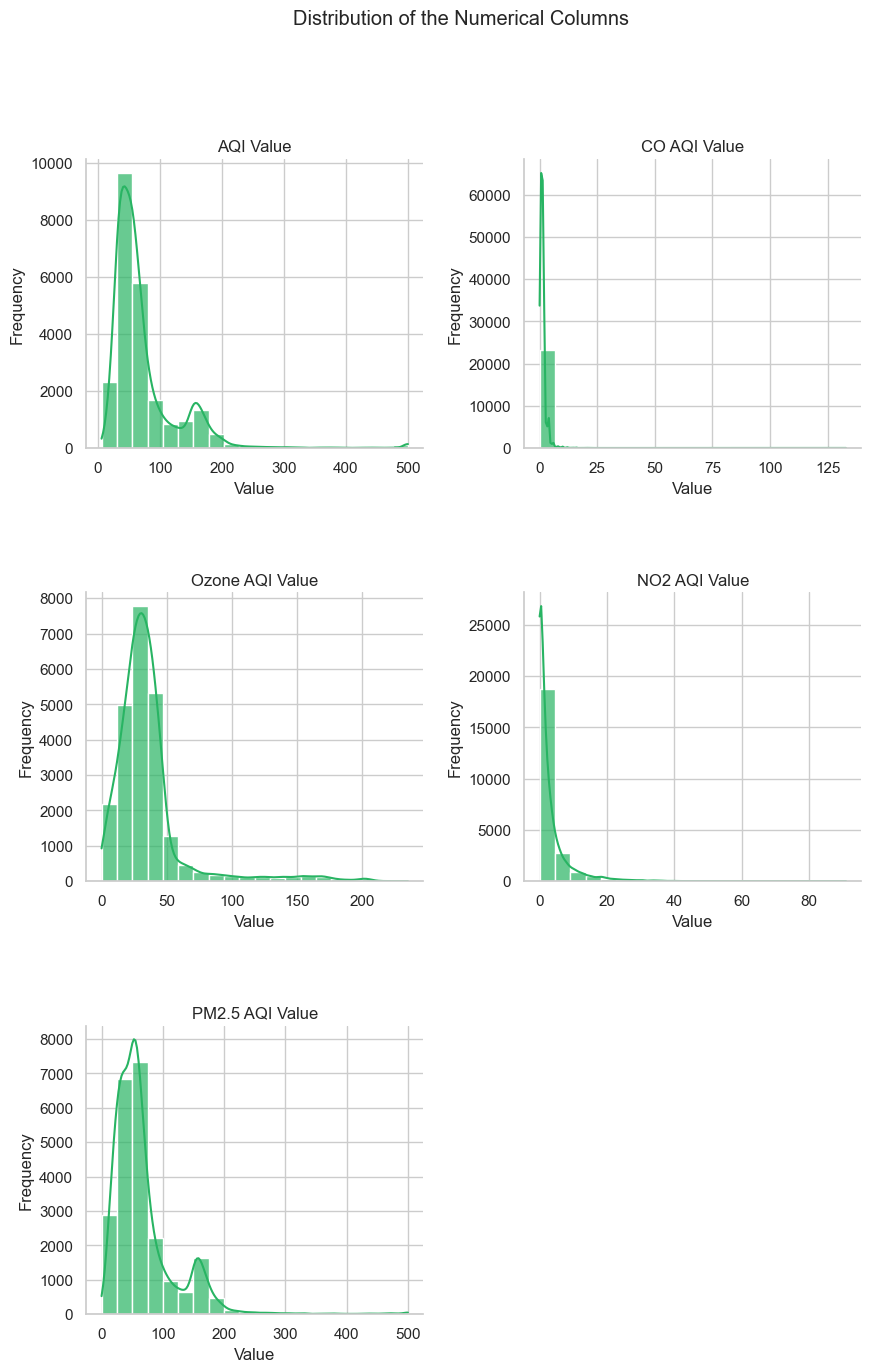

In [15]:
visualize(df_missing, numerical_columns, "histplot", [(10,15),"Distribution of the Numerical Columns", "Value", "Frequency"], False, 2, 0.5)

#### Data Exploration for the Top Country (India) with the highest AQI Value:

In [16]:
print("Table of the top 10 countries with the highest AQI Value")
df_missing.sort_values("AQI Value", ascending=False).groupby("Country").head(1).head(10)

Table of the top 10 countries with the highest AQI Value


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
20567,India,Sasni,500,Hazardous,1,Good,46,Good,1,Good,433,Hazardous
19551,Pakistan,Yazman,500,Hazardous,1,Good,43,Good,0,Good,428,Hazardous
22259,Russian Federation,Tynda,500,Hazardous,21,Good,8,Good,17,Good,475,Hazardous
5156,United States of America,Durango,500,Hazardous,133,Unhealthy for Sensitive Groups,0,Good,53,Moderate,500,Hazardous
18160,South Africa,Boksburg,500,Hazardous,49,Good,1,Good,30,Good,500,Hazardous
13398,Democratic Republic of the Congo,Kasongo Lunda,481,Hazardous,51,Moderate,39,Good,7,Good,446,Hazardous
1402,Republic of Korea,Seoul,421,Hazardous,27,Good,0,Good,91,Moderate,415,Hazardous
11867,China,Chengdu,386,Hazardous,28,Good,0,Good,64,Moderate,386,Hazardous
8547,Mexico,Tepeapulco,384,Hazardous,3,Good,25,Good,6,Good,384,Hazardous
8835,Chile,Lampa,358,Hazardous,28,Good,0,Good,36,Good,358,Hazardous


In [17]:
df_missing["AQI Category"].value_counts()

AQI Category
Good                              9936
Moderate                          9230
Unhealthy                         2227
Unhealthy for Sensitive Groups    1591
Very Unhealthy                     287
Hazardous                          191
Name: count, dtype: int64

In [18]:
print("Good: ", df_missing[(df_missing["Country"] == "India") & (df_missing["AQI Category"] == "Good")].shape[0], "locations")
print("Moderate: ", df_missing[(df_missing["Country"] == "India") & (df_missing["AQI Category"] == "Moderate")].shape[0], "locations")
print("Unhealthy", df_missing[(df_missing["Country"] == "India") & (df_missing["AQI Category"] == "Unhealthy")].shape[0], "locations")
print("Unhealthy for Sensitive Groups: ", df_missing[(df_missing["Country"] == "India") & (df_missing["AQI Category"] == "Unhealthy for Sensitive Groups")].shape[0], "locations")
print("Very Unhealthy: ", df_missing[(df_missing["Country"] == "India") & (df_missing["AQI Category"] == "Very Unhealthy")].shape[0], "locations")
print("Hazardous: ", df_missing[(df_missing["Country"] == "India") & (df_missing["AQI Category"] == "Hazardous")].shape[0], "locations")

Good:  130 locations
Moderate:  585 locations
Unhealthy 1101 locations
Unhealthy for Sensitive Groups:  383 locations
Very Unhealthy:  131 locations
Hazardous:  158 locations


- 71% of all locations in India are from unhealthy to hazardous. 44% of the entries have unhealthy as the **AQI Category** being the highest individual category in India. Furthermore, India occupies the maximum value of **PM2.5 AQI Value, CO AQI Value, and AQI Value**. On average, according to this dataset, the worst conditions are found in India.
- According to the table of the top 10 highest AQI Value countries, the latter occupies the highest **PM2.5 AQI Value** suggesting that it is a common indicator for the **AQI Value.**

#### Data Exploration for the Top Country (Bolivia) with the lowest AQI Value:

In [19]:
print("Table of the top 10 countries with the lowest AQI Value")
df_missing.sort_values("AQI Value", ascending=True).groupby("Country").head(1).head(10)

Table of the top 10 countries with the lowest AQI Value


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
512,Bolivia (Plurinational State of),El Torno,6,Good,0,Good,5,Good,0,Good,6,Good
9194,Ecuador,Macas,7,Good,1,Good,7,Good,0,Good,7,Good
23269,Papua New Guinea,Tari,8,Good,0,Good,8,Good,0,Good,7,Good
7486,Peru,Huaraz,9,Good,0,Good,9,Good,0,Good,8,Good
9607,Indonesia,Manokwari,10,Good,0,Good,10,Good,0,Good,10,Good
16830,Colombia,Guapi,10,Good,1,Good,10,Good,0,Good,10,Good
5527,Argentina,Comodoro Rivadavia,11,Good,0,Good,11,Good,1,Good,4,Good
15343,Brazil,Tarauaca,11,Good,1,Good,2,Good,0,Good,11,Good
19736,Uruguay,Young,11,Good,0,Good,11,Good,1,Good,11,Good
9660,United States of America,Provo,12,Good,0,Good,8,Good,12,Good,7,Good


In [20]:
print("Good: ", df_missing[(df_missing["Country"] == "Bolivia (Plurinational State of)") & (df_missing["AQI Category"] == "Good")].shape[0], "locations")
print("Moderate: ", df_missing[(df_missing["Country"] == "Bolivia (Plurinational State of)") & (df_missing["AQI Category"] == "Moderate")].shape[0], "locations")
print("Unhealthy", df_missing[(df_missing["Country"] == "Bolivia (Plurinational State of)") & (df_missing["AQI Category"] == "Unhealthy")].shape[0], "locations")
print("Unhealthy for Sensitive Groups: ", df_missing[(df_missing["Country"] == "Bolivia (Plurinational State of)") & (df_missing["AQI Category"] == "Unhealthy for Sensitive Groups")].shape[0], "locations")
print("Very Unhealthy: ", df_missing[(df_missing["Country"] == "Bolivia (Plurinational State of)") & (df_missing["AQI Category"] == "Very Unhealthy")].shape[0], "locations")
print("Hazardous: ", df_missing[(df_missing["Country"] == "Bolivia (Plurinational State of)") & (df_missing["AQI Category"] == "Hazardous")].shape[0], "locations")

Good:  31 locations
Moderate:  2 locations
Unhealthy 0 locations
Unhealthy for Sensitive Groups:  0 locations
Very Unhealthy:  0 locations
Hazardous:  0 locations


- 93% of the locations in **Bolivia** have very low **AQI Values** making it a healthy country. Only 0.18% of the places in Bolivia fall under the Moderate AQI quality category.
- According to the table of the lowest AQI Values, the countries exhibit very low levels of all pollutants: **PM2.5, NO2, Ozone, and CO.** This confirms the findings of the previous table that **PM2.5 might have a direct positive relationship with the target variable**. As such, the liquid and solid elements found in the air are a major factor in determining the quality of the air along with the other gases.
- According to both tables, countries from the same location, the same natural and economical regions have different **AQI Values and AQI Category**. For example, the United States of America is in both tables. So, it is reasonable to infer that **Country and City features** are not determining factors for air quality. What matters is the toxic gases and unhealthy components presented in the air such as the pollutants.

**Both should be dropped later before prediction model phase.**

In [21]:
df_missing["AQI Category"].value_counts()
#Domination of the **Good** & **Moderate** categories

AQI Category
Good                              9936
Moderate                          9230
Unhealthy                         2227
Unhealthy for Sensitive Groups    1591
Very Unhealthy                     287
Hazardous                          191
Name: count, dtype: int64

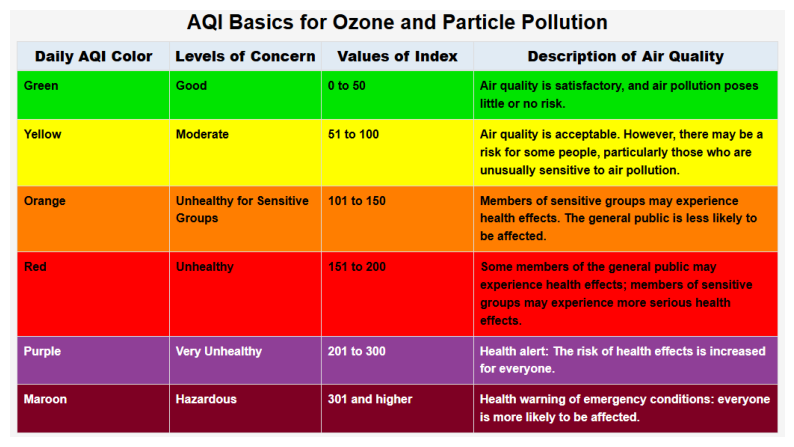

In [22]:
original_link = "https://drive.google.com/file/d/1kFB5h1zwbajibdiGoPKqm6LAhLz3HKhn/view?usp=sharing"
id = "1kFB5h1zwbajibdiGoPKqm6LAhLz3HKhn" # original.split('/')[-2]
url = "https://drive.google.com/uc?id=" + id
image = Image.open(urllib.request.urlopen(url))
img = np.array(image)
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Distribution Report:
- There are two target variables: <b>AQI Value & AQI Category</b>. Both of the target variables will be used for Data Analysis & Exploration.
- According to the distribution of the numerical variables:
<ol>
    <li>All of the numerical columns are positively skewed.</li>
    <li>The most frequent <b>AQI Value</b> are between 25 and 75. This suggests that the <b>AQI Category</b> values are highly aggregated in two categories: Good and Moderate. Based on the value counts and the displayed frequencies, <b>the dataset can be considered as imbalanced</b> with only about 18.3% of the whole dataset is occupied by the rest of the categories: **Unhealthy for Sensitive Groups**, **Unhealthy**, **Very Unhealthy**, and **Hazardous**.</li>
    <li>It is improtant to note that the other numerical features follow the same distribution pattern to the <b>AQI Value</b> especially the <b>Ozone AQI Value</b> and the <b>PM2.5 AQI Value</b>. This suggests a potential high positive correlation between the target variable and the numerical features. For example, according to the table of the top 10 countries with the highest <b>AQI Value</b>, <b>PM2.5 AQI Value</b> often closely matched the high levels of the target variable. <b>Ozone AQI Value</b> also has the same behavior, but less intense. For instance, India has an <b>AQI Value</b> of 500 with a <b>PM2.5 AQI Value</b> contribution of 433 and <b>Ozone AQI Value</b> of 46.</li>
    <li><b>PM2.5 AQI Value</b> histogram displays some mild outliers at the end in the range of 450-500; to be detected and handled later.</li>
</ol>

#### Relationship between the numerical features and the AQI Value:

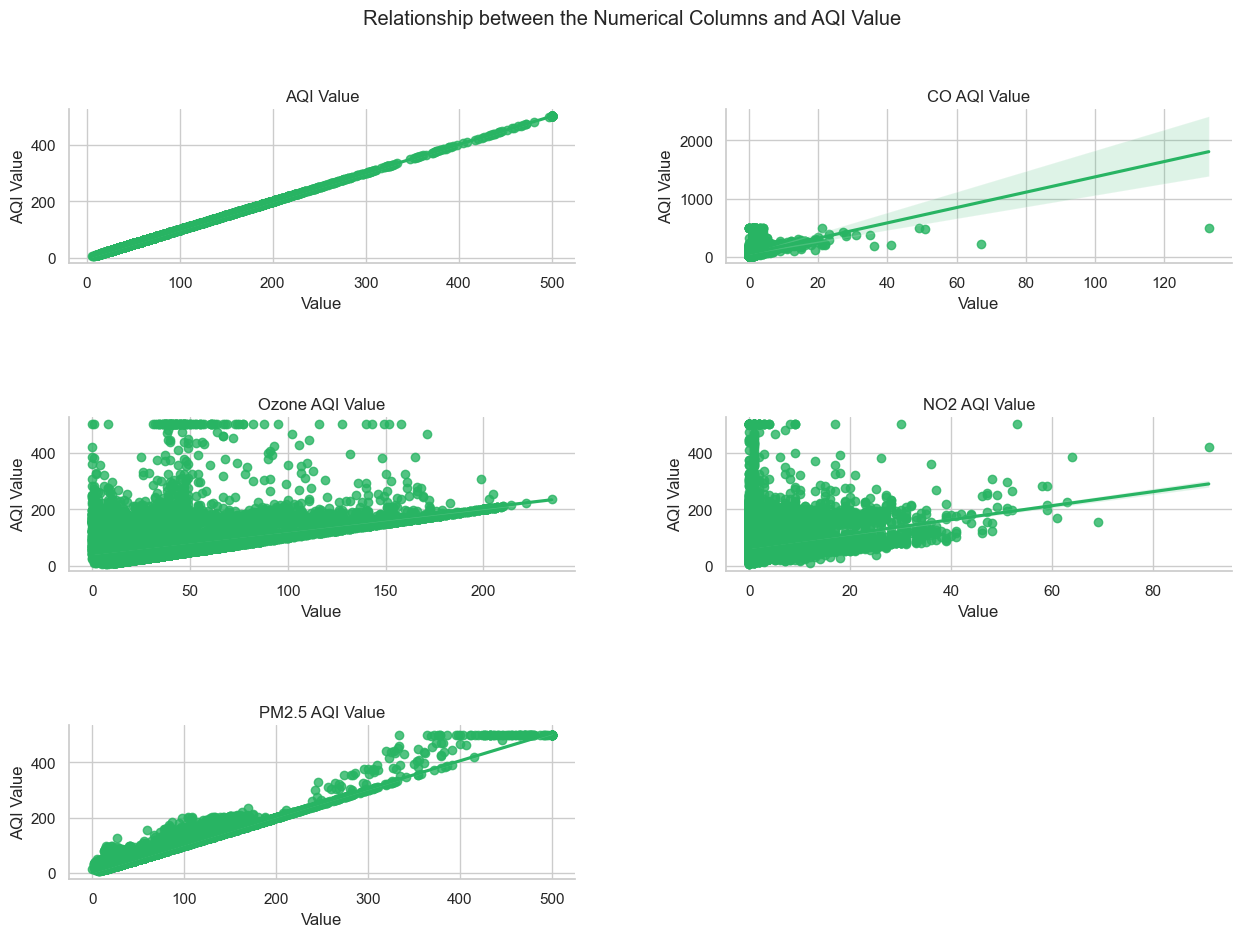

In [23]:
visualize(df_missing, numerical_columns, "scatterfit", [(15,10),"Relationship between the Numerical Columns and AQI Value", "Value", "AQI Value"], False, 2, 1)

##### Report:
According to the scatterplots displayed above:
- The **CO AQI Value** has a linear relationship with the **AQI Value** showing a noticeable ascending pattern. It also shows a wide shaded interval representing the confidence level. Future models might not capture a very accurate relationship between this pollutant and the target variable. 
- While the **Ozone AQI Value** shows a linear trend with the **AQI Value,** the data points are more scattered and spread exhibiting some outliers.
- The **NO2 AQI Value** exhibits a linear trend with the target variable much less correlation than the rest of the pollutants.
- The **PM2.5 AQI Value** demonstrates the strongest linear relationship with the target variable comparing to the other pollutants. In fact, it is really close to the first scatter plot of the general **AQI Value** plot.

**Conclusion:**
<ol>
    <li><b>The target variable AQI Value has a positive relationship with all presented pollutants in the dataset; as their concentration increase the AQI Value increase as well.</b></li>
    <li><b>PM2.5 AQI Value has the strongest relationship with the target variable.</b></li>
</ol>

## Categorical Data Exploration & Visualization

In [24]:
categorical_columns = df_missing.select_dtypes(include=["object"]).drop(columns=["Country","City"], axis=1).columns
categorical_columns

Index(['AQI Category', 'CO AQI Category', 'Ozone AQI Category',
       'NO2 AQI Category', 'PM2.5 AQI Category'],
      dtype='object')

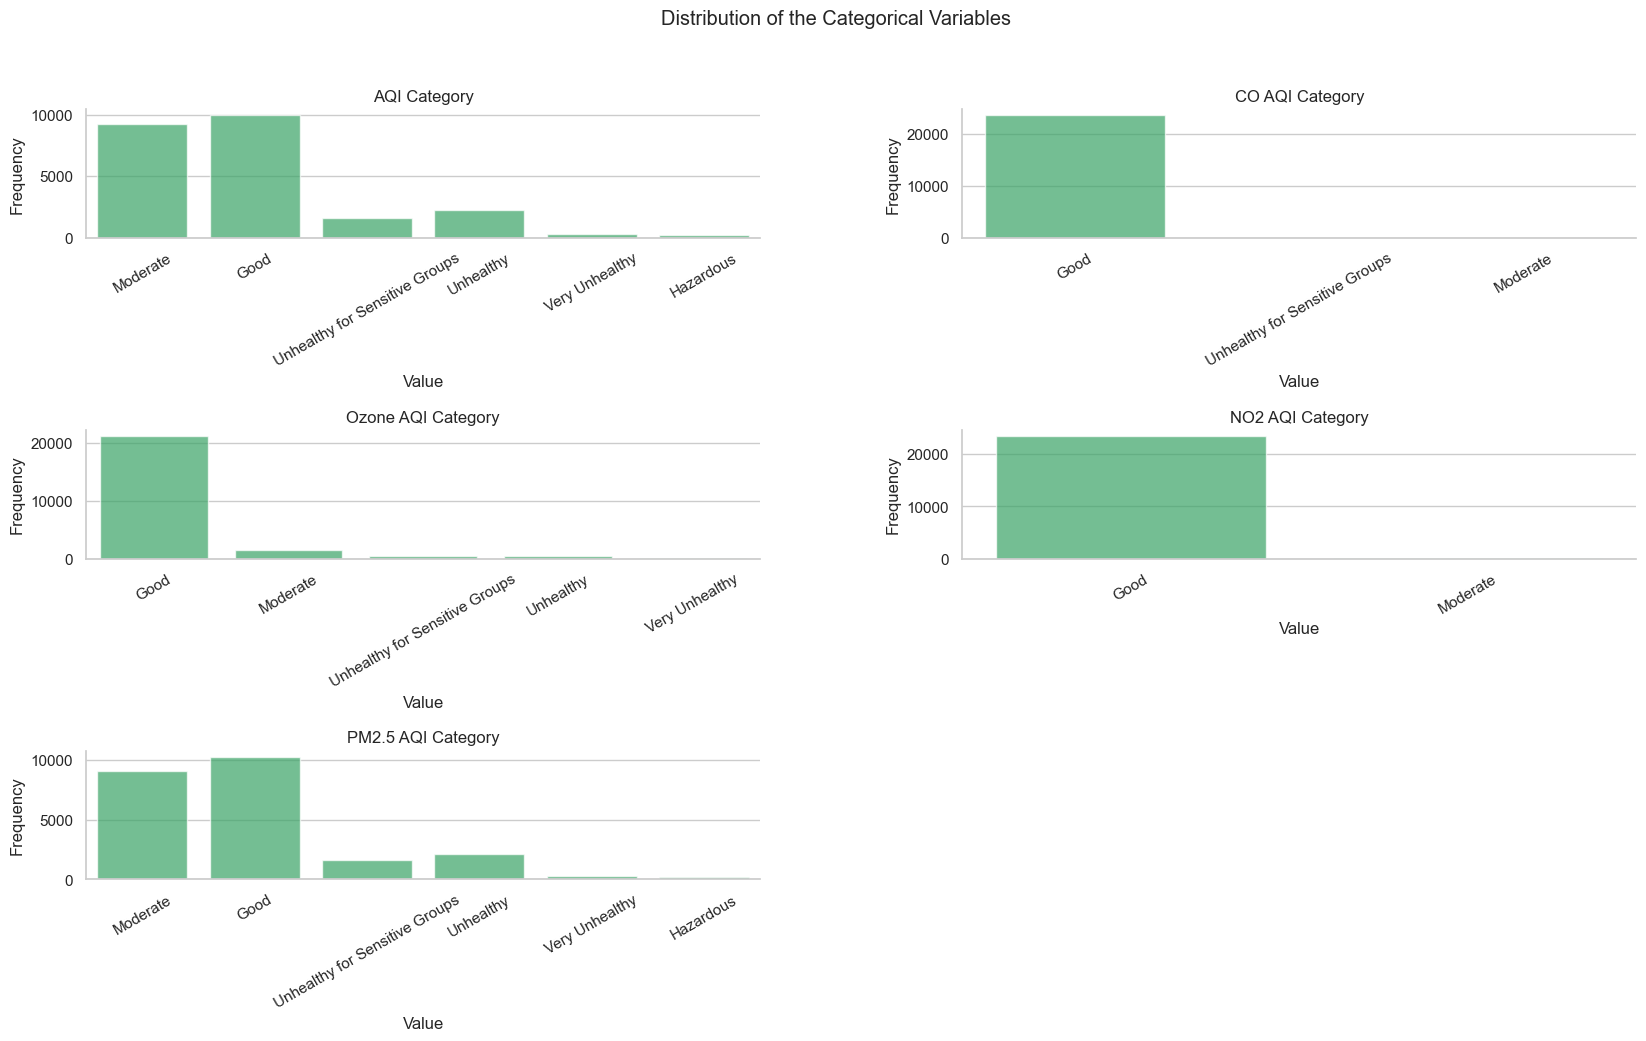

In [25]:
visualize(df_missing, categorical_columns, "countplot", [(20,10),"Distribution of the Categorical Variables", "Value", "Frequency"], True, 2, 1.5)

- Data Imbalance
- Most of them are moderate - good
- PM2.5 AQI Category and Ozone AQI Category are highly correlated with the variables
- The categories can be encoded from 1 to 6 as there is an order between them.

### Ordinal Encoding

In [26]:
category_mapping = {
    "Good":1,
    "Moderate":2,
    "Unhealthy for Sensitive Groups":3,
    "Unhealthy":4,
    "Very Unhealthy":5,
    "Hazardous":6
}
df_encoded = df_missing.copy()
for index, feature in enumerate(categorical_columns):
    df_encoded[feature] = df_encoded[feature].map(category_mapping)

df_encoded.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,2,1,1,36,1,0,1,51,2
1,Brazil,Presidente Dutra,41,1,1,1,5,1,1,1,41,1
2,Italy,Priolo Gargallo,66,2,1,1,39,1,2,1,66,2
3,Poland,Przasnysz,34,1,1,1,34,1,0,1,20,1
4,France,Punaauia,22,1,0,1,22,1,0,1,6,1


#### Relationship of Categorical variables and Target Variable

In [27]:
def chi_square(dataframe, columns):
    if(len(columns) > 2):
        return False
    cross_table = pd.crosstab(dataframe[columns[0]], dataframe[columns[1]])
    chi2, p, dof, expected = chi2_contingency(cross_table)
    return (chi2, p, dof, expected)

for c_index in range(1, len(categorical_columns)):
    chi2, p, _, __ = chi_square(df_encoded,["AQI Category", categorical_columns[c_index]])
    print("The chi score for **", categorical_columns[c_index], "** is", chi2, "and the p value is", p)

The chi score for ** CO AQI Category ** is 222.15515516717153 and the p value is 3.781765344407031e-42
The chi score for ** Ozone AQI Category ** is 11510.313623555498 and the p value is 0.0
The chi score for ** NO2 AQI Category ** is 343.5281493936 and the p value is 4.328720789340713e-72
The chi score for ** PM2.5 AQI Category ** is 103267.52086693948 and the p value is 0.0


- The p value here represents the probability of the null hyptohesis meaning no relationship between the feature to be tested and the target variable **AQI Category**. Having small probability values yields high associations.
The chi-score confirms the high correlation between the categories and the target variable AQI Category.
Aside from the high chi scores, the p values are drastically low. The **Ozone AQI Category and PM2.5 AQI Category** having perfect and complete association with the target variable with 0 p values. The **CO AQI Category** and the **NO2 AQI Category** having *3.8e-42* and *4.3e-72* respectively also infers an indispensable relationship with the target variable AQI Category.
- The distribution of the target variable **AQI Category** and the target variable **AQI Value** have very similar patterns. This is consistent with the table of classification of the AQI Index provided by WHO and other govermental enviromental agencies.<br />
Same thing is applied for the rest pollutants AQI indices.

## Outlier Detection & Handling:

### IQR Method:

In [28]:
for column in numerical_columns:
    inner_fence = calculate_fence(df_encoded, column, 1.5)
    outer_fence = calculate_fence(df_encoded, column, 3)
    mild_outliers = df_encoded[((df_encoded[column] < inner_fence[0]) & (df_encoded[column] >= outer_fence[0])) |
                                ((df_encoded[column] > inner_fence[1]) & (df_encoded[column] <= outer_fence[1]))]
    extreme_outliers = df_encoded[(df_encoded[column] < outer_fence[0]) | (df_encoded[column] > outer_fence[1])]
    print(column, inner_fence, outer_fence)
    print(f"The {column} has {mild_outliers.shape[0]} mild outliers and {extreme_outliers.shape[0]} extreme outliers\n")


AQI Value [-21.0, 139.0] [-81.0, 199.0]
The AQI Value has 2446 mild outliers and 489 extreme outliers

CO AQI Value [1.0, 1.0] [1.0, 1.0]
The CO AQI Value has 0 mild outliers and 8596 extreme outliers

Ozone AQI Value [-7.5, 68.5] [-36.0, 97.0]
The Ozone AQI Value has 541 mild outliers and 972 extreme outliers

NO2 AQI Value [-6.0, 10.0] [-12.0, 16.0]
The NO2 AQI Value has 905 mild outliers and 776 extreme outliers

PM2.5 AQI Value [-31.0, 145.0] [-97.0, 211.0]
The PM2.5 AQI Value has 2277 mild outliers and 364 extreme outliers



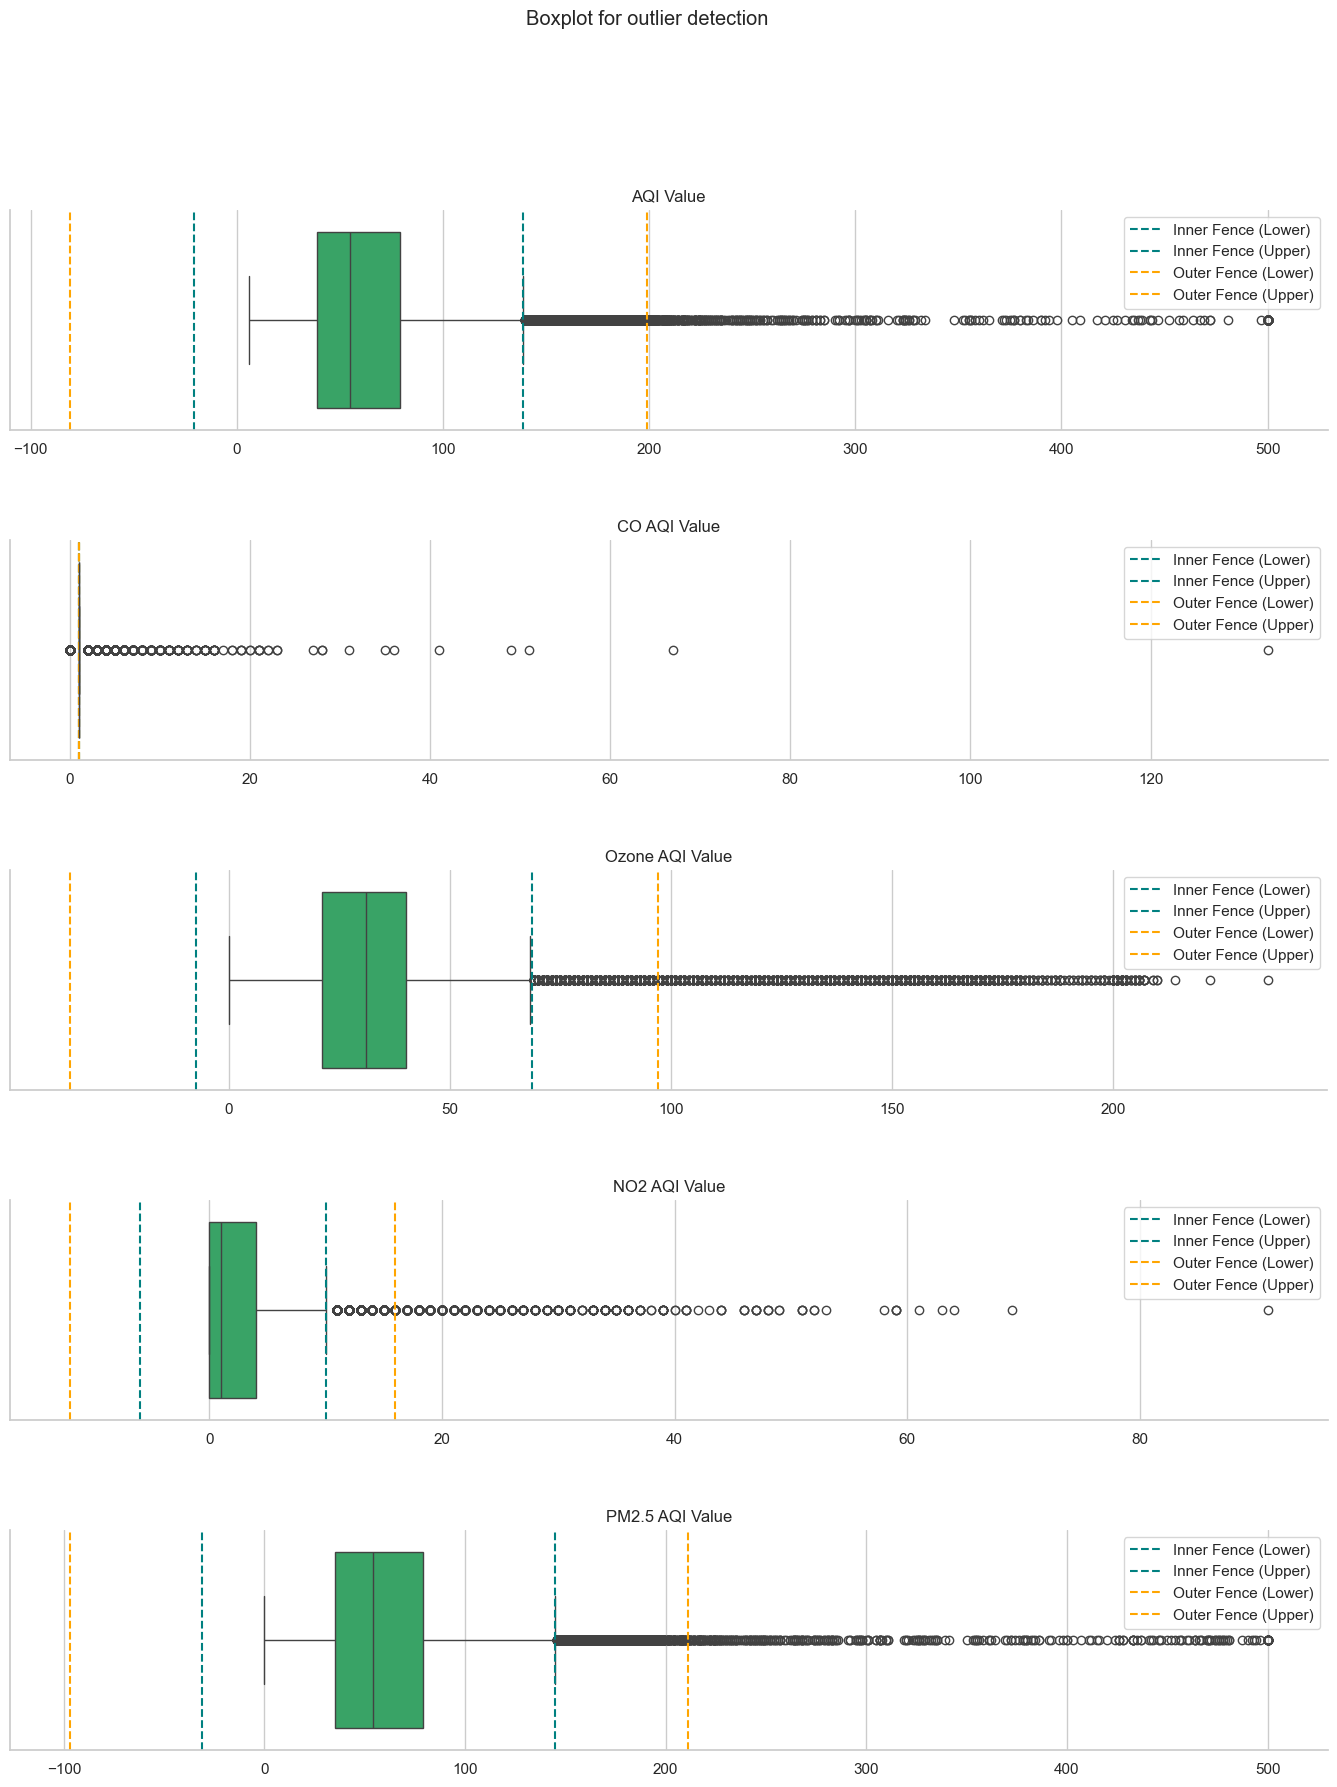

In [29]:
visualize(df_encoded, numerical_columns, "boxplot", [(17,20), "Boxplot for outlier detection", "", ""], False, 1, 0.5)

In [30]:
df_missing["AQI Category"].value_counts()

AQI Category
Good                              9936
Moderate                          9230
Unhealthy                         2227
Unhealthy for Sensitive Groups    1591
Very Unhealthy                     287
Hazardous                          191
Name: count, dtype: int64

- Visualization methods as histograms and boxplots indicate that the extreme outliers found were the group of countries and cities where the AQI Category was part of the minorty groups such as Hazardous, Very Unhealthy, and Unhealthy, with maximum **AQI Value** of 500 and maximum **PM2.5 AQI Value** of 500. The outliers are also found in all of the features.
- Statistical methods were used for outlier detection. Because of the skewness of all features and their non-normal distribution IQR is more robust and much less sensitive to non-normal distributed data than the Standard Score Z-score for instance.
- [According to this categorical column distribution visualization](#Categorical-Columns:), there is a very low percentage of some groups such as Hazardous, Very Unhealthy, and Unhealthy. This was detected as extreme outliers by the Statitical IQR Method and the boxplots. Removing or imputing such groups would lead to the loss of information and diminishment of groups so introducing bias to the models. These low frequent data points should not be considered as outliers but should be handled later on with data imabalance handling techniques such as undersampling and Synthetic Minority Oversampling Technique (SMOTE). There are 23462 entries in the dataset. Only applying SMOTE might inflate the dataset and introduce more noise, as a result both undersampling and SMOTE can be applied 
- Feature engineering can be applied as well to group these extreme outliers into one column or one class of very dangerous AQI states ranging from: unhealthy, very unhealthy, and hazardous with their corresponding ordinal values 4, 5, and 6 respectively. So the resultant column will occupy 11.52% of the whole dataset. This will be verified later on with **Clustering Analysis.**
- Data imbalance handling techniques still needs to be applied.

## Correlation

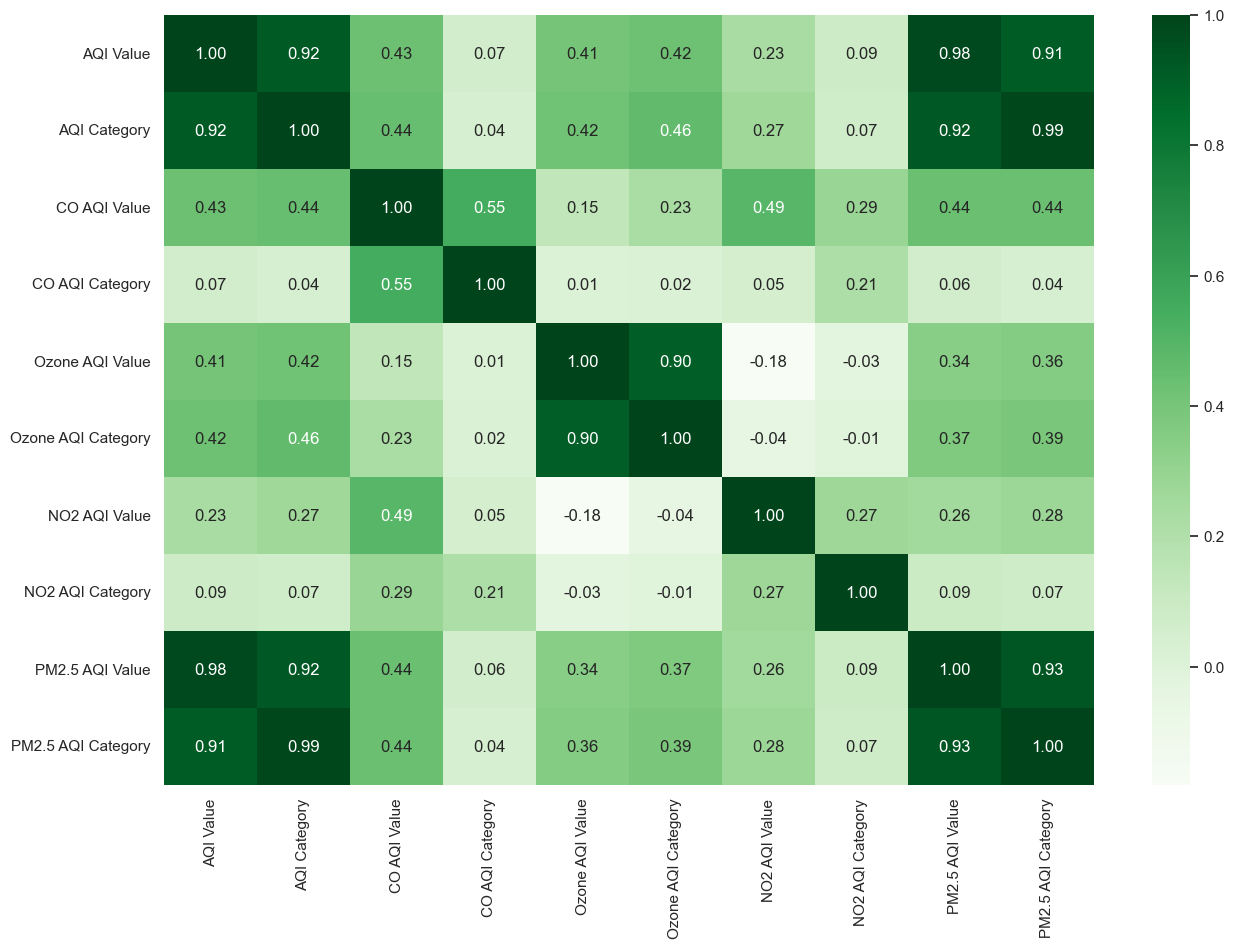

In [31]:
columns_to_drop = ["Country","City"]
df_dropped = df_encoded.drop(columns=columns_to_drop, axis=1)
df_dropped.head()
plt.figure(figsize=(15,10))
sns.heatmap(df_dropped.corr(), cmap="Greens", annot=True,fmt=".2f")
plt.show()

#### Correlation Heatmap Report:
- The correlation between the target variable **AQI Value & AQI Category**(0.92) and the features **PM2.5 AQI Value & PM2.5 AQI Category**(0.93) further emphasizes the strong influence between these variables.
- The correlation value between **AQI Value and AQI Category** is 0.92 which suggests that the categories(good, moderate, unhealthy...) effectively represent the values of the air quality index.
- The target variables and the features are both highly correlated. As a result, no more columns will be dropped for the prediction models.
- **Ozone AQI Value and Ozone AQI Category** are closely tied with a near-perfect correlation of 0.90. Same thing applied to the **PM2.5 AQI Value and PM2.5 AQI Category** with a high correlation of 0.93. The categorical variables accurately represent and classify the values of the AQI of the pollutants.
- **NO2 AQI Value and NO2 AQI Category** have a low correlation of 0.27. This suggests that the values are not well aligned with the categories. The same occurs with **CO AQI Value and CO AQI Category** having a moderate correlation of 0.55. As a result, it is very crucial to seperate the AQI Value for pollutants and their corresponding categorical features for regression or/and classification. For regression, using only the numerical features to predict the **AQI Value** will yield a better model for fitting by abstaining from including conflicting information. Same thing for classification, using only the categorical features to predict the **AQI Category** has the potential to produce a more accurate model. Combining all features is considered as redunduncy and introudces noise which could hinder the performance of both models.
- There is a negative correlation between **NO2 AQI Value** and **Ozone AQI Value.** This is actually related to the nature of Ozone formation. Chemically speaking, Ozone is formed by the reactions of NO2 with sunlight which creates oxygen which in turn forms O3 or Ozone. So Ozone is more present in sunny days while NO2 is more present in heavy-densily polluted areas due to vehicles for instance. As a result, NO2 can increase in the evenings or at night while the Ozone is decreasing which explains the negative correlation.

**Conclusion:**
- **No more features will be dropped from the dataset.**
- **For regression models, only numerical features will be used to predict the numerical variable AQI Value.**
- **For classification models, the focus will be exclusively on the categorical features to predict the categorical variable AQI Category.**

## Data Normalization:

#### Numerical Features Normalization:

In [32]:
numerical_features = ["CO AQI Value","Ozone AQI Value","NO2 AQI Value","PM2.5 AQI Value"]
normalizer = MinMaxScaler()
df_normalized = df_dropped.copy()
df_normalized[numerical_features] = normalizer.fit_transform(df_normalized[numerical_features])

#### Categorical Features Normalization:

In [33]:
categorical_features = ["CO AQI Category","Ozone AQI Category","NO2 AQI Category","PM2.5 AQI Category"]
scaler = StandardScaler()
df_normalized[categorical_features] = scaler.fit_transform(df_normalized[categorical_features])
df_normalized.head()

,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,51,2,0.007519,-0.010662,0.153191,-0.295117,0.000000,-0.025293,0.102,0.118525
1,41,1,0.007519,-0.010662,0.021277,-0.295117,0.010989,-0.025293,0.082,-0.849391
2,66,2,0.007519,-0.010662,0.165957,-0.295117,0.021978,-0.025293,0.132,0.118525
3,34,1,0.007519,-0.010662,0.144681,-0.295117,0.000000,-0.025293,0.040,-0.849391
4,22,1,0.000000,-0.010662,0.093617,-0.295117,0.000000,-0.025293,0.012,-0.849391


## Normalized AQI Category: 
- **Good: 0 -> 0.1**
- **Moderate: 0.1 -> 0.2**
- **Unhealthy for sensitive groups: 0.2 -> 0.3**
- **Unhealthy: 0.3 -> 0.4**
- **Very Unhealthy: 0.4->0.6**
- **Hazardous: 0.6 -> 1**

## Clustering Analysis:
The AQI system communicates the quality of air through classifying the AQI Value into **six** categories.
- Good
- Moderate
- Unhealthy for sensitive people
- Unhealthy
- Very Unhealthy
- Hazardous.

**As a result, for clustering analysis, k = 6 will be used.**

The elbow method will be also implemented to find the 
optimal k.

### Applying PCA

In [34]:
df_model = df_normalized[["AQI Category","CO AQI Value", "Ozone AQI Value", "NO2 AQI Value", "PM2.5 AQI Value"]].copy()

In [35]:
df_model.head(3)

,AQI Category,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,2,0.007519,0.153191,0.000000,0.102
1,1,0.007519,0.021277,0.010989,0.082
2,2,0.007519,0.165957,0.021978,0.132


In [36]:
df_model

,AQI Category,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,2,0.007519,0.153191,0.000000,0.102
1,1,0.007519,0.021277,0.010989,0.082
2,2,0.007519,0.165957,0.021978,0.132
3,1,0.007519,0.144681,0.000000,0.040
4,1,0.000000,0.093617,0.000000,0.012
...,...,...,...,...,...
23458,4,0.022556,0.655319,0.021978,0.368
23459,1,0.007519,0.085106,0.054945,0.100
23460,1,0.007519,0.093617,0.010989,0.100
23461,2,0.007519,0.187234,0.021978,0.142


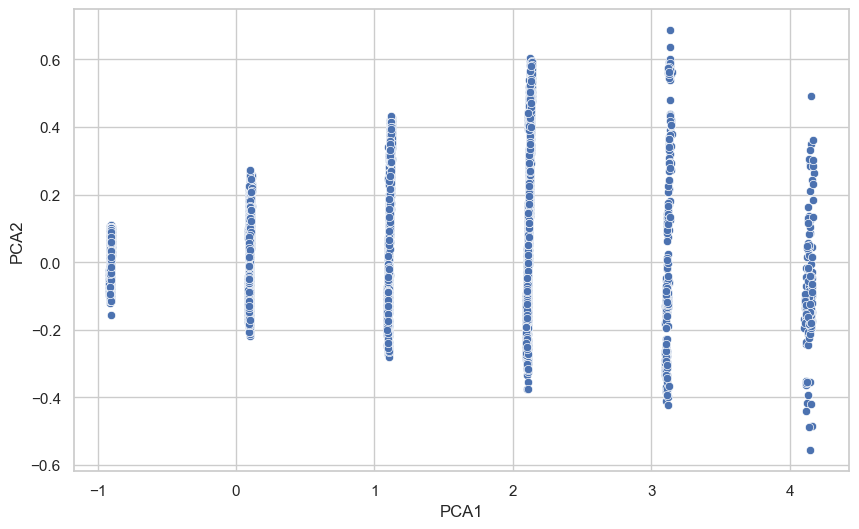

In [37]:
pca = PCA() 
pca_components = pca.fit_transform(df_model) 
df_model.loc[: ,"PCA1"] = pca_components[:, 0] 
df_model.loc[:, "PCA2"] = pca_components[:, 1] # Plotting the clusters 
plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=df_model, x="PCA1", y="PCA2")
plt.show()

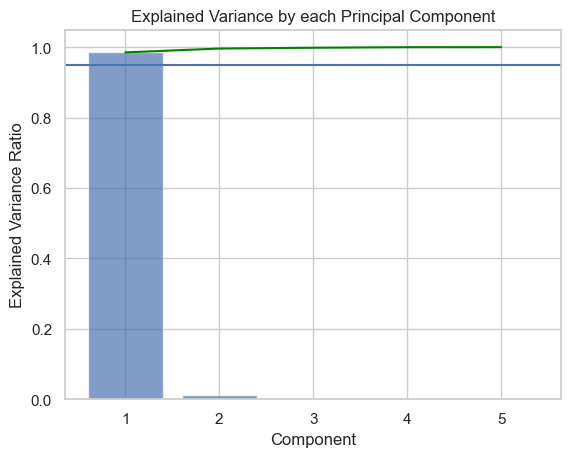

In [38]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1,len(cumulative_variance) + 1), cumulative_variance, label="test", color="green")
plt.axhline(y=0.95)
plt.title("Explained Variance by each Principal Component")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

2 Principal components are enough for data preservation.

In [39]:
df_pca = df_model[["PCA1","PCA2"]]
df_model = df_model.drop(columns=["PCA1", "PCA2"], axis=1)

In [40]:
df_pca.head(3)

,PCA1,PCA2
0,0.092300,0.009331
1,-0.909877,-0.082699
2,0.096116,0.015044


### Exploring the Elbow Method Optimal k

In [41]:
def optimal_k(dataframe):
    inertia = []
    for k in range(1,11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto", init="k-means++") #random_state is added so not to change the name order of the clusters each time the code is run
        kmeans.fit(dataframe)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6)) 
    sns.lineplot(x=range(1,11), y=inertia, marker="o") 
    plt.title("Optimal K - Elbow Method") 
    plt.xlabel('K - Number of Clusters') 
    plt.ylabel('Inertia - Sum of Squared Distances')
    plt.show()

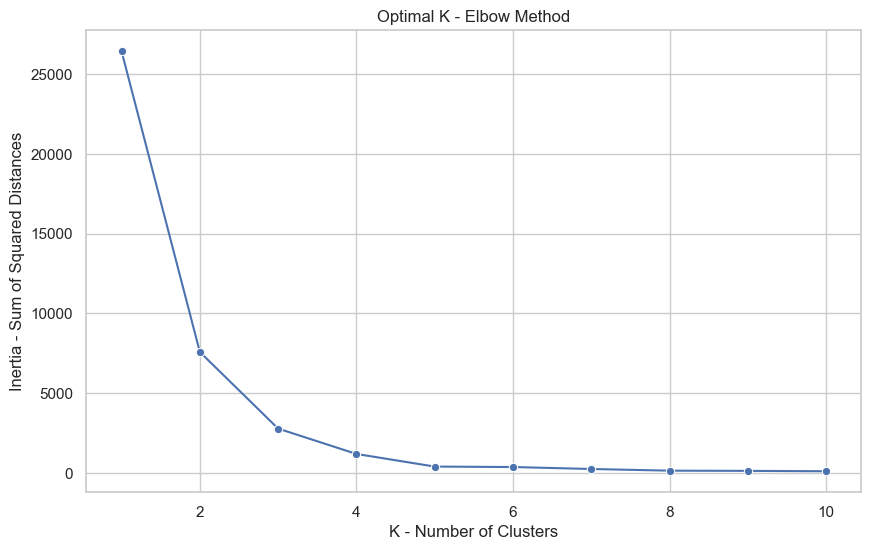

In [42]:
optimal_k(df_pca)

In [43]:
df_pca = apply_kmean(df_pca, 3)
print("Silhouette Score:",silhouette_score(df_pca.drop(columns=["Cluster"], axis=1), df_pca["Cluster"]))

Silhouette Score: 0.8462184986891301


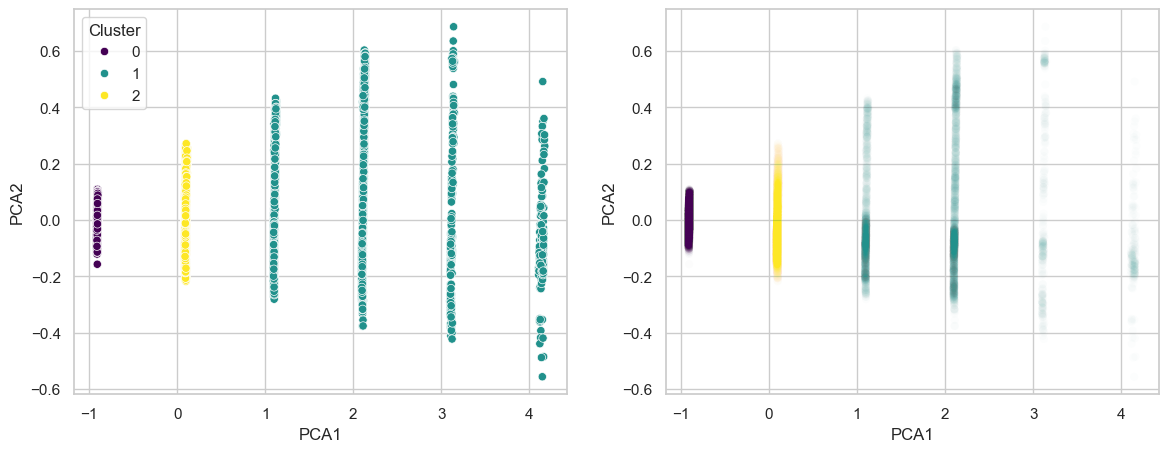

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", ax=axes[0])
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", alpha=0.01, legend=False, ax=axes[1])
plt.show()

While the 0 cluster or the purple cluster is lower in "height" than the other clusters it exhibits the highest number of data points. The data points are on top of each other. The two scatter plots demonstrate this by decreasing the opacity of the each data point to display what lies behind in the right scatter.

#### Data Recovery & AQI Category Mapping

In [45]:
df_test = df_normalized.copy().drop(columns=["AQI Value", "CO AQI Category","Ozone AQI Category", "NO2 AQI Category", "PM2.5 AQI Category"])
df_test["Cluster"] = df_pca["Cluster"]
df_test["AQI Category"] = df_normalized["AQI Category"]

In [46]:
df_test.head(3) #Dataset with their

,AQI Category,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,Cluster
0,2,0.007519,0.153191,0.000000,0.102,2
1,1,0.007519,0.021277,0.010989,0.082,0
2,2,0.007519,0.165957,0.021978,0.132,2


In [47]:
df_test_0 = df_test[df_test["Cluster"] == 0]
df_test_1 = df_test[df_test["Cluster"] == 1]
df_test_2 = df_test[df_test["Cluster"] == 2]

In [48]:
df_test_0["AQI Category"].value_counts()

AQI Category
1    9936
Name: count, dtype: int64

In [49]:
df_test_1["AQI Category"].value_counts()

AQI Category
4    2227
3    1591
5     287
6     191
Name: count, dtype: int64

In [50]:
df_test_2["AQI Category"].value_counts()

AQI Category
2    9230
Name: count, dtype: int64

#### Descriptive Table For the First Cluster

In [51]:
df_test_0.describe()

,AQI Category,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,Cluster
count,9936.0,9936.000000,9936.000000,9936.000000,9936.000000,9936.0
mean,1.0,0.005808,0.120371,0.016227,0.063199,0.0
std,0.0,0.003470,0.044978,0.022642,0.022903,0.0
min,1.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.0,0.007519,0.089362,0.000000,0.046000,0.0
50%,1.0,0.007519,0.123404,0.010989,0.064000,0.0
75%,1.0,0.007519,0.153191,0.021978,0.082000,0.0
max,1.0,0.030075,0.212766,0.274725,0.100000,0.0


#### Descriptive Table For the Second Cluster

In [52]:
df_test_1.describe()

,AQI Category,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,Cluster
count,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,4296.0
mean,3.785382,0.021877,0.253379,0.060452,0.321083,1.0
std,0.754362,0.027734,0.224162,0.092657,0.127683,0.0
min,3.000000,0.000000,0.000000,0.000000,0.054000,1.0
25%,3.000000,0.007519,0.102128,0.000000,0.248000,1.0
50%,4.000000,0.015038,0.165957,0.021978,0.308000,1.0
75%,4.000000,0.030075,0.374468,0.076923,0.340000,1.0
max,6.000000,1.000000,1.000000,1.000000,1.000000,1.0


#### Descriptive Table For the Third Cluster

In [53]:
df_test_2.describe()

,AQI Category,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,Cluster
count,9230.0,9230.000000,9230.000000,9230.000000,9230.000000,9230.0
mean,2.0,0.009718,0.133164,0.039963,0.130867,2.0
std,0.0,0.005196,0.067669,0.056801,0.026579,0.0
min,2.0,0.000000,0.000000,0.000000,0.024000,2.0
25%,2.0,0.007519,0.089362,0.000000,0.112000,2.0
50%,2.0,0.007519,0.127660,0.021978,0.126000,2.0
75%,2.0,0.015038,0.174468,0.054945,0.146000,2.0
max,2.0,0.097744,0.421277,0.428571,0.198000,2.0


#### Observation & Inferences:
- **Cluster 0:**: the first cluster occupies about 42% of the whole dataset. According to [the descriptive table for the first cluster](#Descriptive-Table-for-The-First-Cluster:) and the [Normalized AQI Category](#Normalized-AQI-Category:),the mean values of the pollutants are 0.006, 0.12, 0.02, and 0.063 for CO AQI Value, Ozone AQI Value, NO2 AQI Value, and PM2.5 AQI Value respecitvely. The standard deviation of the pollutants are not substantial suggesting aggregation of the pollutant values around their means. In fact, all of the pollutants exhibit a low AQI Values that are part of the Good category except the Ozone AQI Value having a maximum of 0.21 and the NO2 AQI Value having a maximum of 0.27. These inconsistent values only represent a small minority due to the clustering algorithm. As a result, validating the findings of the previous observations and visualizations, pollutants are very important for AQI Category classification. According to the [AQI Categorical Mapping For the first cluster](#AQI-Categorical-Mapping:), the first group is in fact heavily dominated by this categories: Good - Like was supposed before.<br />
**Conclusion: Cluster 0 represent Good category.**


- **Cluster 1:** The second cluster occupies about 5% of the whole dataset. According to [the descriptive table for the second cluster](#Descriptive-Table-for-The-Second-Cluster:) and the Normalized AQI Category, the mean values of the pollutants are 0.02, 0.25, 0.06, and 0.32 for CO AQI Value, Ozone AQI Value, NO2 AQI Value, and PM2.5 AQI Value respecitvely. The standard deviation for the Ozone AQI Value and PM2.5 AQI Value is high, the values are driven away from the mean. Actually the 50% and 75% percentile of the PM2.5 and Ozone pollutants are classified as unhealthy. Mapping the AQI Categories to these clusters yields the unhealthy and unhealthy for sensitive people categories. According to the AQI Category mapping in this cluster, all of the hazardous entries are present here.<br />
**Conclusion: Cluster 1 mainly groups the unhealthy, unhealthy for sensitive people, very unhealthy, and hazardous categories**

- **Cluster 2**: The final cluster occupies about 12% of the whole dataset. According to [the descriptive table for the third cluster](#Descriptive-Table-for-The-Third-Cluster:) and the Normalized AQI Category, the mean values of the pollutants are 0.01, 0.13, 0.04, and 0.13  for CO AQI Value, Ozone AQI Value, NO2 AQI Value, and PM2.5 AQI Value respecitvely. This cluster exhibits a lower standard deviation than the previous cluster with the highest being 0.13 for PM2.5 AQI Value and Ozone AQI Value. This suggests a low variability among the values making them tightly clustered around the mean. <br />
**Conclusion: the third cluster mainly groups the moderate category.**.


- **The three clusters empahsizes the relationship between the pollutants. In the first cluster all of the majority of the pollutants AQI Values exhibited a very low value indicating Good or Moderate. While it is important to build classification models to accurately predict these categories, it is beneficial to merge and reduce these six categories into three categories as was done in clustering. Not just the classification models will be simpler and faster, but the categories will be pronounced mitigating the issue of data imbalance without less reliability on synthesis data. <br /> Since both datasets, undersampling & normal, emphasized the grouping of unhealthy variants and hazardous, then that alone can be considered as class. The other two classes will be good & moderate. Good & moderate won't be combined into two classes for two reasons. The first one is not to make the model too simple and the second one not to inflate the data imbalance.**


### Exploring k = 6

In [54]:
df_pca_k_6 = df_pca.drop(columns=["Cluster"], axis=1)
df_pca_k_6 = apply_kmean(df_pca_k_6, 6)
print("Silhouette Score:",silhouette_score(df_pca_k_6.drop(columns=["Cluster"], axis=1), df_pca_k_6["Cluster"]))

Silhouette Score: 0.7526743232783341


In [55]:
df_pca_k_6.head()

,PCA1,PCA2,Cluster
0,0.092300,0.009331,5
1,-0.909877,-0.082699,0
2,0.096116,0.015044,5
3,-0.908159,0.042482,0
4,-0.913341,-0.005327,0


In [56]:
df_pca_k_6["Cluster"].value_counts()

Cluster
0    9936
2    4755
5    4475
1    2227
3    1591
4     478
Name: count, dtype: int64

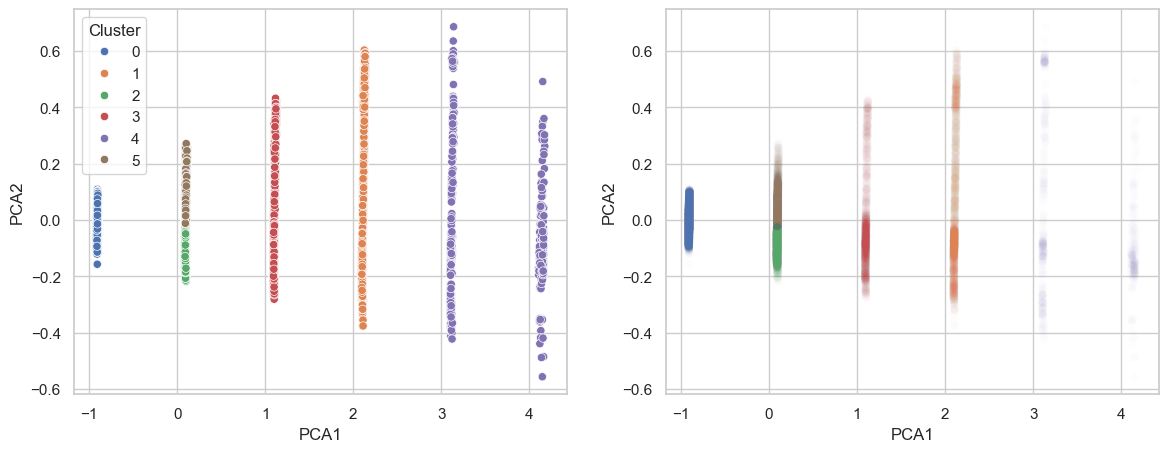

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(data=df_pca_k_6, x="PCA1", y="PCA2", hue="Cluster", palette="deep", ax=axes[0])
sns.scatterplot(data=df_pca_k_6, x="PCA1", y="PCA2", hue="Cluster", palette="deep", alpha=0.01, legend=False, ax=axes[1])
plt.show()

While the 0 cluster or the blue cluster is lower in "height" than the other clusters it exhibits the highest number of data points. The data points are on top of each other. The two scatter plots demonstrate this by decreasing the opacity of the each data point to display what lies behind in the right plot.

### Data Recovery & AQI Category Mapping

In [58]:
df_model["Cluster"] = df_pca_k_6["Cluster"]

In [59]:
df_model["Cluster"].value_counts()

Cluster
0    9936
2    4755
5    4475
1    2227
3    1591
4     478
Name: count, dtype: int64

In [60]:
df_model["AQI Category"].value_counts()

AQI Category
1    9936
2    9230
4    2227
3    1591
5     287
6     191
Name: count, dtype: int64

In [61]:
for i in range(6):
    print("Cluster: ", i , "\n",df_model[df_model["Cluster"] == i]["AQI Category"].value_counts(), "\n\n")

Cluster:  0 
 AQI Category
1    9936
Name: count, dtype: int64 


Cluster:  1 
 AQI Category
4    2227
Name: count, dtype: int64 


Cluster:  2 
 AQI Category
2    4755
Name: count, dtype: int64 


Cluster:  3 
 AQI Category
3    1591
Name: count, dtype: int64 


Cluster:  4 
 AQI Category
5    287
6    191
Name: count, dtype: int64 


Cluster:  5 
 AQI Category
2    4475
Name: count, dtype: int64 




- **AQI Category 1 - Good - was successfully identified as cluster 0**
- **AQI Category 2 - Moderate - was identified as cluster 2 and cluster 5**
- **AQI Category 3 - Unhealthy for sensitive people - was identified as cluster 3**
- **AQI Category 4 - Unhealthy - was identified as cluster 1**
- **AQI Category 5 & 6 - Very unhealthy and hazardous was identified as cluster 4**

#### Observations & Inferences:
- The dataset was nearly accurately clustered where each group was perfectly mapped to its own cluster. The Hazardous and very unhealthy were not seperated as the rest of the clusters however. In addition, two clustered had the same AQI Category which was Moderate. Yet, this dataset has yileded better results than the rest. This is mainly due to the data imbalance. A a result, to have a more robust and accurate classification and regression models, data imbalance resolution will be applied.
- **SMOTE OR/AND Undersampling dataset will be used for classification mainly and kmean for regression.**
- **The original imbalanced dataset will be used with its 6 classes. It will be used mainly for linear regression since it is not very susceptible to data imbalance.**

## Class Reduction:

In [62]:
categories = [4,5,6]
categorical_columns = ["AQI Category","CO AQI Category","Ozone AQI Category","NO2 AQI Category","PM2.5 AQI Category"]
df_combined = df_normalized.copy()
for column in categorical_columns:
     df_combined[column] = df_combined[column].replace(categories, 3)

In [63]:
print("Old:\n", df_normalized["AQI Category"].value_counts(),"\n")
print("New:\n",df_combined["AQI Category"].value_counts())

Old:
 AQI Category
1    9936
2    9230
4    2227
3    1591
5     287
6     191
Name: count, dtype: int64 

New:
 AQI Category
1    9936
2    9230
3    4296
Name: count, dtype: int64


## Final Datasets To Be Used:


### Recap:
- Only one missing value removed
- No outliers removed
- Countries & Cities features removed
- PM2.5 and Ozone are the highest correlated pollutants with the target variables.
- For regression only numerical features.
- For classification only categorical features.
- **Three datasets will be used: Imbalanced dataset - Class Reduction Dataset - SMOTE and/or undersampled dataset**

### Regression:

In [64]:
df_regression = df_normalized.copy()
df_regression.drop(columns=["AQI Category","CO AQI Category","Ozone AQI Category","NO2 AQI Category","PM2.5 AQI Category"], axis=1, inplace=True)

### Classification:

In [65]:
df_classification_0 = df_normalized.copy()
df_classification_1 = df_combined.copy()

df_classification_0.drop(columns=["AQI Value","CO AQI Value","Ozone AQI Value","NO2 AQI Value", "PM2.5 AQI Value"], axis=1, inplace=True)
df_classification_1.drop(columns=["AQI Value","CO AQI Value","Ozone AQI Value","NO2 AQI Value", "PM2.5 AQI Value"], axis=1, inplace=True)

| Dataset            | Special Characteristic                                                                                                          |
|--------------------|---------------------------------------------------------------------------------------------------------------------------------|
|**df_classification_0** | Feature aggregation was not applied here<br /> i.e the values of the AQI Category for pollutants were not combined<br /> together into a single value. |
|**df_classification_1** | Featreu aggregation was applied<br /> i.e the value of the AQI Category for pollutants were combined together.<br /> The values combined are: 5,6 into 4. |

# **REFERENCES:**
- **Ambien Air pollution from the World Health Organization: https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health?gad_source=1&gclid=CjwKCAiAjp-7BhBZEiwAmh9rBTH7g0PF6HSoibuvb9O558R-H_Npkx20MgDdsWGYRiznambg25ATIhoC8cgQAvD_BwE**
- **Basics of AQI Category meanings from the US Goverment: https://www.airnow.gov/aqi/aqi-basics/**
- **Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index (AQ from the US Environmental Protection Agency: https://web.archive.org/web/20201026120832/https://www.airnow.gov/sites/default/files/2018-05/aqi-technical-assistance-document-may2016.pdf/**
- **Ground Level Ozone Basics: https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics**